In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout
import numpy as np

Using TensorFlow backend.


In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
# load dataset
term11=1
#term11=2
#term11=3
#term11=4
dataset = read_csv('data_LSTM_cprec_noheight.csv', header=0, index_col=0)
values = dataset.values
# divide data about check number

datacheck = [None] * 10

for j in range(1,5) :
    datacheck[j] = dataset.values[dataset.check==j,:]
    
scaled=datacheck

# frame as supervised learning

reframed = [None] * 10

for j in range(1,5) :
    reframed[j] = series_to_supervised(scaled[j], 1, 1)

In [4]:
#1

# drop columns we don't want to predict
for j in range(1,5) :
    reframed[j].drop(reframed[j].columns[[12,13,14,15,16,17,18,19,20,21,22,24,25]], axis=1, inplace=True)

In [5]:
# split into train and test sets

train = [None] * 10
test = [None] * 10

for j in range(1,5) :
    
    values = reframed[j].values
    n_train_hours = round(len(reframed[j])*0.8)
        
    train[j] = values[:n_train_hours, :]
    test[j] = values[n_train_hours:, :]

In [6]:
# split into input and outputs

train_X = [None] * 10
train_y = [None] * 10
test_X  = [None] * 10
test_y  = [None] * 10

for j in range(1,5) :
    
    if(j==term11) : 
        train_X[j], train_y[j] = train[j][:, :-1], train[j][:, -1]
        test_X[j], test_y[j] = test[j][:, :-1], test[j][:, -1]
        test_hatX, test_haty = test[j][:, :-1], test[j][:, -1]
    
    else : 
        train_X[j], train_y[j] = train[j][:, :-1], train[j][:, -1]
        test_X[j], test_y[j] = test[j][:, :-1], test[j][:, -1]

# reshape input to be 3D [samples, timesteps, features]
for j in range(1,5) :
    train_X[j] = train_X[j].reshape((train_X[j].shape[0], 1, train_X[j].shape[1]))
    test_X[j] = test_X[j].reshape((test_X[j].shape[0], 1, test_X[j].shape[1]))


test_hatX = test_hatX.reshape((test_hatX.shape[0], 1, test_hatX.shape[1]))
print(train_X[1].shape, train_y[1].shape, test_X[1].shape, test_y[1].shape)

(1550, 1, 12) (1550,) (387, 1, 12) (387,)


In [7]:
from keras import backend as K

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred -y_true), axis=-1))

# design network
model = Sequential()
model.add(LSTM(128,input_shape=(train_X[1].shape[1], train_X[1].shape[2]),
               return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(32))
model.add(Dropout(0.1))

model.add(Dense(1))
#model.compile(loss='mae', optimizer='adam')
model.compile(optimizer='adam', loss='mean_squared_error',  metrics=[rmse, r2_keras])

# fit network
for j in range(1,5) :
    history = model.fit(train_X[j], train_y[j], epochs=50, batch_size=24, 
                        #validation_data=(test_X[j], test_y[j]),
                        verbose=2, shuffle=False)

Epoch 1/50
 - 3s - loss: 0.0889 - rmse: 0.2390 - r2_keras: -2.3856e+01
Epoch 2/50
 - 0s - loss: 0.0200 - rmse: 0.1015 - r2_keras: -2.2466e+00
Epoch 3/50
 - 0s - loss: 0.0164 - rmse: 0.0914 - r2_keras: -1.5985e+00
Epoch 4/50
 - 0s - loss: 0.0139 - rmse: 0.0854 - r2_keras: -1.2195e+00
Epoch 5/50
 - 0s - loss: 0.0112 - rmse: 0.0765 - r2_keras: -8.5594e-01
Epoch 6/50
 - 0s - loss: 0.0083 - rmse: 0.0671 - r2_keras: -3.6706e-01
Epoch 7/50
 - 0s - loss: 0.0072 - rmse: 0.0635 - r2_keras: -2.5557e-01
Epoch 8/50
 - 0s - loss: 0.0060 - rmse: 0.0583 - r2_keras: -1.1252e-01
Epoch 9/50
 - 0s - loss: 0.0057 - rmse: 0.0576 - r2_keras: -8.2294e-02
Epoch 10/50
 - 0s - loss: 0.0053 - rmse: 0.0557 - r2_keras: -5.8694e-02
Epoch 11/50
 - 0s - loss: 0.0042 - rmse: 0.0491 - r2_keras: 0.1890
Epoch 12/50
 - 0s - loss: 0.0038 - rmse: 0.0472 - r2_keras: 0.2304
Epoch 13/50
 - 0s - loss: 0.0034 - rmse: 0.0440 - r2_keras: 0.3821
Epoch 14/50
 - 0s - loss: 0.0033 - rmse: 0.0435 - r2_keras: 0.3745
Epoch 15/50
 - 0s - l

Epoch 23/50
 - 0s - loss: 0.0030 - rmse: 0.0325 - r2_keras: 0.6414
Epoch 24/50
 - 0s - loss: 0.0030 - rmse: 0.0331 - r2_keras: 0.6139
Epoch 25/50
 - 0s - loss: 0.0030 - rmse: 0.0333 - r2_keras: 0.5978
Epoch 26/50
 - 0s - loss: 0.0030 - rmse: 0.0334 - r2_keras: 0.6155
Epoch 27/50
 - 0s - loss: 0.0030 - rmse: 0.0335 - r2_keras: 0.6129
Epoch 28/50
 - 0s - loss: 0.0029 - rmse: 0.0322 - r2_keras: 0.6409
Epoch 29/50
 - 0s - loss: 0.0031 - rmse: 0.0342 - r2_keras: 0.6133
Epoch 30/50
 - 0s - loss: 0.0031 - rmse: 0.0347 - r2_keras: 0.5757
Epoch 31/50
 - 0s - loss: 0.0031 - rmse: 0.0345 - r2_keras: 0.5746
Epoch 32/50
 - 0s - loss: 0.0030 - rmse: 0.0333 - r2_keras: 0.6209
Epoch 33/50
 - 0s - loss: 0.0030 - rmse: 0.0335 - r2_keras: 0.6203
Epoch 34/50
 - 0s - loss: 0.0030 - rmse: 0.0340 - r2_keras: 0.6007
Epoch 35/50
 - 0s - loss: 0.0031 - rmse: 0.0347 - r2_keras: 0.5806
Epoch 36/50
 - 0s - loss: 0.0030 - rmse: 0.0338 - r2_keras: 0.6163
Epoch 37/50
 - 0s - loss: 0.0030 - rmse: 0.0340 - r2_keras: 0.

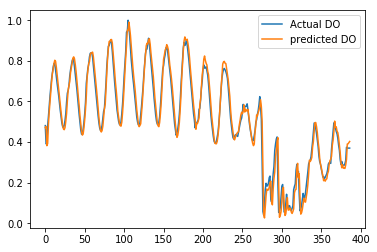

In [8]:
# make a prediction
yhat = model.predict(test_hatX)
test_hatX = test_hatX.reshape((test_hatX.shape[0], test_hatX.shape[2]))
pyplot.plot(test_haty, label='Actual DO')
pyplot.plot(yhat, label='predicted DO')
pyplot.legend()
pyplot.show()

y1=yhat
#y1
check=len(y1)
check1=len(y1)-1

In [9]:
#4
maxmax=[0,11.83,13.01,12.56,9.29]
minmin=[0,0,0.85,0.04,0]
for j in range(0,check) :
        test_haty[j] = (test_haty[j]* maxmax[term11] )+ minmin[term11]
        y1[j] = (y1[j]* maxmax[term11] )+ minmin[term11]

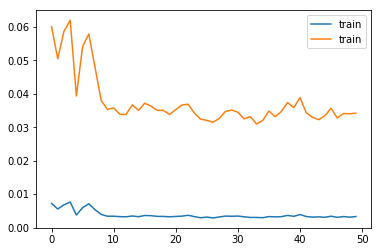

Test RMSE: 0.237
Test R^2: 0.992


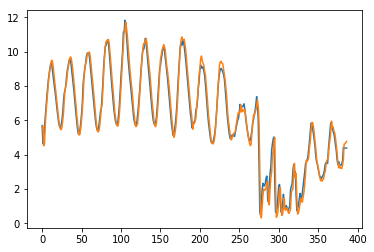

In [10]:
# plot history
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test')
pyplot.plot(history.history['rmse'], label='train')
#pyplot.plot(history.history['r2_keras'], label='train')
pyplot.legend()
pyplot.show()
from keras import backend as K

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred -y_true), axis=-1))


# calculate RMSE
rmse = sqrt(mean_squared_error(test_haty[1:check1], y1[2:check]))
print('Test RMSE: %.3f' % rmse)

from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(test_haty[1:check1], y1[2:check])
print('Test R^2: %.3f' % coefficient_of_dermination)
#coefficient_of_dermination1 = r2_score(test_haty[96:119], y1[97:120])
#print('Test R^2: %.3f' % coefficient_of_dermination1)


pyplot.plot(test_haty)
pyplot.plot(y1)
#pyplot.plot(yhat_t)
pyplot.show()
#파랑 예측 주황 실측

In [11]:
#term11=1
#term11=2
#term11=3
term11=4

(1550, 1, 12) (1550,) (387, 1, 12) (387,)


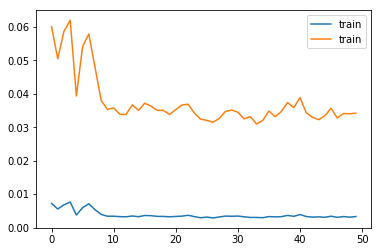

Test RMSE: 0.027
Test R^2: 0.929


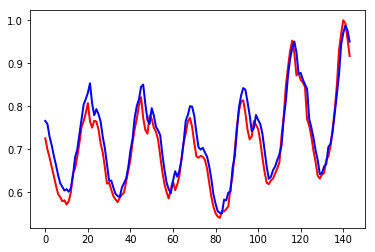

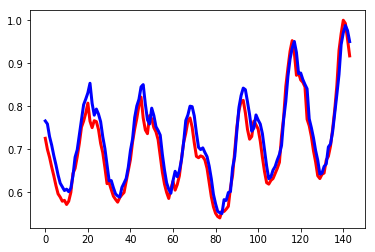

In [12]:
# load dataset

dataset = read_csv('data_LSTM_cprec_noheight.csv', header=0, index_col=0)
values = dataset.values
# divide data about check number

datacheck = [None] * 10

for j in range(1,5) :
    datacheck[j] = dataset.values[dataset.check==j,:]
    
scaled=datacheck

# frame as supervised learning

reframed = [None] * 10

for j in range(1,5) :
    reframed[j] = series_to_supervised(scaled[j], 1, 1)

#1

# drop columns we don't want to predict
for j in range(1,5) :
    reframed[j].drop(reframed[j].columns[[12,13,14,15,16,17,18,19,20,21,22,24,25]], axis=1, inplace=True)


# split into train and test sets

train = [None] * 10
test = [None] * 10

for j in range(1,5) :
    
    values = reframed[j].values
    n_train_hours = round(len(reframed[j])*0.8)
        
    train[j] = values[:n_train_hours, :]
    test[j] = values[n_train_hours:, :]


# split into input and outputs

train_X = [None] * 10
train_y = [None] * 10
test_X  = [None] * 10
test_y  = [None] * 10

for j in range(1,5) :
    
    if(j==term11) : 
        train_X[j], train_y[j] = train[j][:, :-1], train[j][:, -1]
        test_X[j], test_y[j] = test[j][:, :-1], test[j][:, -1]
        test_hatX, test_haty = test[j][:, :-1], test[j][:, -1]
    
    else : 
        train_X[j], train_y[j] = train[j][:, :-1], train[j][:, -1]
        test_X[j], test_y[j] = test[j][:, :-1], test[j][:, -1]

# reshape input to be 3D [samples, timesteps, features]
for j in range(1,5) :
    train_X[j] = train_X[j].reshape((train_X[j].shape[0], 1, train_X[j].shape[1]))
    test_X[j] = test_X[j].reshape((test_X[j].shape[0], 1, test_X[j].shape[1]))


test_hatX = test_hatX.reshape((test_hatX.shape[0], 1, test_hatX.shape[1]))
print(train_X[1].shape, train_y[1].shape, test_X[1].shape, test_y[1].shape)


# make a prediction
yhat = model.predict(test_hatX)
test_hatX = test_hatX.reshape((test_hatX.shape[0], test_hatX.shape[2]))


y1=yhat
#y1
check=len(y1)
check1=len(y1)-1


#4
#maxmax=[0,11.83,13.01,12.56,9.29]
#minmin=[0,0,0.85,0.04,0]
#for j in range(0,check) :
#        test_haty[j] = (test_haty[j]* maxmax[term11] )+ minmin[term11]
#        y1[j] = (y1[j]* maxmax[term11] )+ minmin[term11]

# plot history
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test')
pyplot.plot(history.history['rmse'], label='train')
#pyplot.plot(history.history['r2_keras'], label='train')
pyplot.legend()
pyplot.show()
from keras import backend as K

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred -y_true), axis=-1))


# calculate RMSE
rmse = sqrt(mean_squared_error(test_haty[1:check1], y1[2:check]))
print('Test RMSE: %.3f' % rmse)

from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(test_haty[1:check1], y1[2:check])
print('Test R^2: %.3f' % coefficient_of_dermination)
#coefficient_of_dermination1 = r2_score(test_haty[96:119], y1[97:120])
#print('Test R^2: %.3f' % coefficient_of_dermination1)


pyplot.plot(test_haty, color='r', linewidth=2.0)
pyplot.plot(y1, color='b', linewidth=2.0)
#pyplot.plot(yhat_t)
pyplot.show()
#파랑 예측 주황 실측

pyplot.plot(test_haty, color='r', linewidth=3.0)
pyplot.plot(y1, color='b', linewidth=3.0)
#pyplot.plot(yhat_t)
pyplot.show()
#파랑 예측 주황 실측

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from keras.models import load_model
import shap



In [15]:
regressor = model

In [16]:
pred_x = regressor.predict_classes(train_X[1])
random_ind = np.random.choice(train_X[1].shape[0], 1000, replace=False)
#print(random_ind)



In [17]:
data = train_X[1][random_ind[0:500]]
e = shap.DeepExplainer((regressor.layers[0].input, regressor.layers[-1].output),data)
test1 = train_X[1][random_ind[500:1000]]

In [18]:
shap_val = e.shap_values(test1)

In [19]:
shap_val = np.array(shap_val)

In [20]:
shap_val.shape[1],shap_val.shape[2],shap_val.shape[3]

(500, 1, 12)

In [21]:
shap_val = np.reshape(shap_val,(int(shap_val.shape[1]),int(shap_val.shape[2]),int(shap_val.shape[3])))
shap_abs = np.absolute(shap_val)

In [22]:
sum_0 = np.sum(shap_abs,axis=0)
f_names = ['wtemp1','pH1','DO1','EC1','Turb1','SS1','TN1','TP1','TOC1','level_ti1','DO_t1','prec1']
#wtemp	pH	EC	DO	Turb	SS	TN	TP	TOC	height	DO_t	cprec

x_pos = [i for i, _ in enumerate(f_names)]

x_pos





[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

IndexError: index 1 is out of bounds for axis 0 with size 1

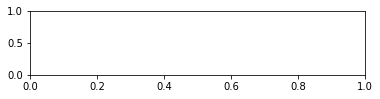

In [23]:
plt1 = plt.subplot(311)
plt1.barh(x_pos,sum_0[1])
plt1.set_yticks(x_pos)
plt1.set_yticklabels(f_names)
plt1.set_title("Yesterday’s features (time-step 6)")




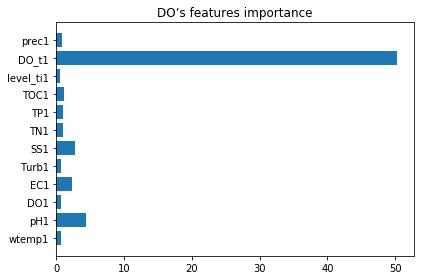

In [24]:
plt2 = plt.subplot(111,sharex=plt1)
plt2.barh(x_pos,sum_0[0])
plt2.set_yticks(x_pos)
plt2.set_yticklabels(f_names)
plt2.set_title("DO’s features importance")
plt.figure
plt.tight_layout()
plt.show()


In [25]:
sum_0[0]

array([ 0.70905187,  4.38016806,  0.77008037,  2.37599097,  0.76508895,
        2.75848626,  1.05984447,  1.02561926,  1.15148254,  0.55905823,
       50.27515039,  0.81619565])

In [ ]:
f_names = ['wtemp1','pH1','DO1','EC1','Turb1','SS1','TN1','TP1','TOC1',,'level_ti1','DO_t1','prec1']